# LLM Python Tutorial
### Author: Adam Hollings, Sam Hollings
<a target="_blank" href="https://colab.research.google.com/github/nhsengland/llm_tutorial/blob/main/llm_python_tutorial.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This tutorial will show you how easy it is to get some simple large language models (LLMs) running, locally either on collab or your own device.

## Why run locally?
Locals models use the compute where they are run so you need not worry about having to purchase API keys such as with services like chatGPT. Local models can also be deployed in locked down enviornments without access to the internet.

## After this tutorial?
Consider trying different local models from huggingface. Try out different prompting strategies from learnprompting.org. You could also try and have persistant chat. Figure out what you want to achieve and then get the model and output that most suits it.

## Setup
Nothing! This tutorial can run without any setup.

We are using open source local models from HuggingFace. Some require you to login to a huggingface account and enter a HuggingFace API key to use them; for simplicity I have avoided those today.

### Sources
Inspired by [Sam Hollings' LLM tutorials](https://github.com/SamHollings/llm_tutorial/tree/main)

# Introduction
Although the behind the scenes of how a generative pre-trained [transformer](https://en.wikipedia.org/wiki/Attention_Is_All_You_Need) (GPT) is complex, actually running your own is now very simple. The training is the most data and resource intense step; a pretained model removes this and allows you to play around and use the output of that training. What the model was trained on and how many parameters it has will greatly affect its performance in different situations.

The main packages needed are transformers and accelerate, beyond that it can vary by model.

We will install the needed libraries bellow:

In [ ]:
#@title

# this forces google collab to install the dependencies
if "google.colab" in str(get_ipython()):
    print("Running on Colab")
    !git clone https://github.com/nhsengland/llm_tutorial.git -q
    %cd llm_tutorial
    !pip install -q -r requirements.txt

# Microsoft Phi-3-mini-4k-instruct

This is a small version of Phi-3, a generic "SLM (small language model)" by microsoft which can be used as a chat bot. There are also larger Phi-3-small and Phi-3-medium models that perform better in tests but use more computer.
We will use the Phi-3-mini-4k model to create a basic chat bot.

You can see more information on Phi-3-mini-4k-instruct [here](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct)

The cell below downloads the model and sets up the model pipeline:


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

torch.random.manual_seed(0)
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)

tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

Now the model is ready we can give it a system prompt and then say something to it to generate a response.

**system** is the system prompt; it tells the model how to act.
**user** is the user input; the model will respond to this.

In [ ]:

generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "temperature": 0.7,
    "do_sample": True,
}

messages = [
    {"role": "system", "content": "You are a helpful AI assistant."},
    {"role": "user", "content": """Write me an email thanking Leeds Hospital
    for its hard work. Fill in details about my condition randomly"""},
]

output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

This works but I think its a bit boring. Lets jazz it up a bit.

Can you change the prompt to answer:

1.   In the style of a pirate
2.   In Chinese text
3.   Create your own idea



In [ ]:
generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "temperature": 0.7,
    "do_sample": True,
}

messages = [
    {"role": "system", "content": """
    Your name is WOPR which stands for Writing Ordering Punctuating Reading.
    You are an advanced proof reader who is excellent at suggesting advice on
    writing style, content, grammar and word choice.
    Answer as if you are a robot, must use emoticons in every answer.
    Begin and end the response with BEEP BOOP.
    Energetic answer with emoticon in every sentence. Social media style.
    Easy reading spread over multple lines:
    """},
    {"role": "user", "content": "Wot is teh capitul city of Chiner"},
]

output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

**Challenges**

*   Few shot examples in the messages?
*   Prompt engineering examples - get some. https://learnprompting.org/docs/basic_applications/summarize
- - What purpose do each of the sentences have in the system prompt?
*   "The output must be in this format. My job depends on it"
*   Changing the temperature
*   Chat history
*   A different model?







"one shot prompting" is where you give it an example of what you want it to see.
This makes the output more consistently like what you would expect. There are also "few shot prompts" where you might include multiple examples.
You can also try things such as "chain of thought" where the example is broken
down into logical steps, or "zero-shot chain of thought" where you simply ask the model to "think things through".

Giving examples can be useful for example if you want the model to imitate your
writing style. The length of the text you can pass in is determined by the "context window"; this model has a small context window but there are large
context versions available.

An example of a "one shot prompt" is below; can you make your own up as well?

In [ ]:
messages = [
    {"role": "system", "content": "You are a helpful AI assistant."},
    {"role": "user", "content": """Can you provide ways to eat combinations of
    bananas and dragonfruits?"""},
    {"role": "assistant", "content": """Sure! Here are some ways to eat bananas
    and dragonfruits together: 1. Banana and dragonfruit smoothie: Blend bananas
    and dragonfruits together with some milk and honey. 2. Banana and dragonfruit
    salad: Mix sliced bananas and dragonfruits together with some lemon juice and
    honey."""},
    {"role": "user", "content": "What about solving an 2x + 3 = 7 equation?"},
]

output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

# Specialist Model

Specialist models can outperform generalist models in their area of expertise at the expense of a limited use case. We will look at a couple of examples.

# Grammarly CoEdit
This is a simple model that has one aim; it corrects grammar and spelling. It will not engage in conversation but gives a very consistent output which is just a correction of the grammar and spelling in the input, if asked to fix grammar and / or spelling.

See more information on this model [here]( https://huggingface.co/grammarly/coedit-large)

In [ ]:
from transformers import AutoTokenizer, T5ForConditionalGeneration

tokenizer = AutoTokenizer.from_pretrained("grammarly/coedit-large")
model = T5ForConditionalGeneration.from_pretrained("grammarly/coedit-large")

In [ ]:
input_text = 'Fix grammatical errors in this sentence: When I grow up, I start to understand what he said is quite right.'
input_ids = tokenizer(input_text, return_tensors="pt").input_ids
outputs = model.generate(input_ids, max_length=256)
edited_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(edited_text)

In [ ]:
input_text = 'Fix grammatical errors in this sentence: I learned him how to play snooker'
input_ids = tokenizer(input_text, return_tensors="pt").input_ids
outputs = model.generate(input_ids, max_length=256)
edited_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(edited_text)

# Cappy Scorer
[Cappy](https://huggingface.co/btan2/cappy-large) is a model which takes a question and an answer then scores them between 0 and 1; if the response is correct or sensible it gets a high score. A wrong answer gets 0. This model has [out performed much more complex models](https://research.google/blog/cappy-outperforming-and-boosting-large-multi-task-language-models-with-a-small-scorer/?m=1&utm_source=pocket_reader&utm_medium=email) on tasks involving evaluating answer suitability despite being very small.


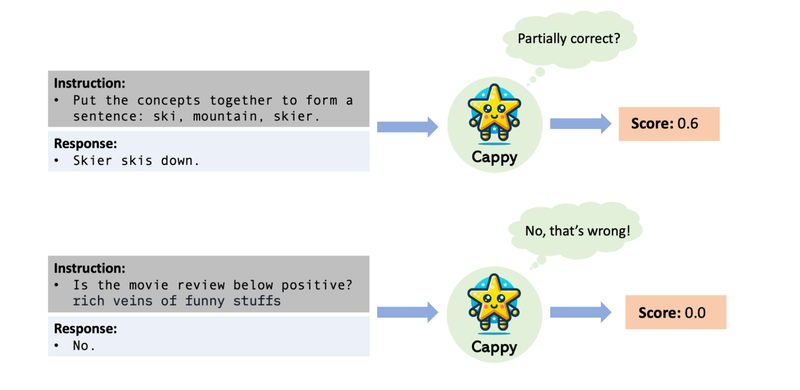

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('btan2/cappy-large')
cappy = AutoModelForSequenceClassification.from_pretrained('btan2/cappy-large')

This first example scores highly:

In [ ]:
instruction = """
Why was the NHS created in the United Kingdom?
"""
response = """The NHS was made to provide universal healthcare, free at the point of use."""

inputs = tokenizer([(instruction, response), ], return_tensors='pt')
score = cappy(**inputs).logits[0][0].item()
print(score)

The second one scores less well - perhaps because it's too long

In [ ]:
instruction = """
Why was the NHS created in the United Kingdom?
"""
response = """The NHS was set up in 1948 to provide everyone in the UK with
healthcare based on their needs, and not on their ability to pay.
Labour's Minister for Health Aneurin Bevan is popularly considered the NHS's
founder, despite never formally being referred to as such."""

inputs = tokenizer([(instruction, response), ], return_tensors='pt')
score = cappy(**inputs).logits[0][0].item()
print(score)

As we can see below, Cappy seems to prefer succinct answers:

In [ ]:
instruction = """
What is the capital of the United Kingdom?
"""
response = """London."""

inputs = tokenizer([(instruction, response), ], return_tensors='pt')
score = cappy(**inputs).logits[0][0].item()
print(score)

But can also find incorrect responses:

In [ ]:
instruction = """
What is the capital of the United Kingdom?
"""
response = """Leeds."""

inputs = tokenizer([(instruction, response), ], return_tensors='pt')
score = cappy(**inputs).logits[0][0].item()
print(score)

# Applications of GPTs / LLMs / SLMs

Actual practical use cases

*   Summarising text and confirming that the summary is valid.
*   Writing emails quickly.
*   Anything that usually follows a formal consistent format.
*   Writing social media posts e.g. linkedin
*   Providing example / skeleton programming code for common operations.
*   Idea generation e.g. mnemonics, presentation titles, keywords on a topic
*   Poetry
*   Image generation

Get feedback from attendees